## INTRODUCTION

Big data is helping law enforcement in a big way. Police officers sometimes feel like they’re playing Whac-A-Mole — they work to decrease illegal activity in a high-crime area, only to have it pop up somewhere else. To solve this problem, I replicated the risk terrain modeling (RTM) developed by Joel Caplan. This approach takes an area and blends its history of crime with data on local behavioral and physical characteristics to create a map of locations with the greatest crime risk and helps police officers predict where new hot spots could arise.

## PROBLEM STATEMENT

In this project, I will try to replicate the work of Joel Caplan. Joel Caplan worked on the problem that solved the problem of schedule policing which has long-term positive outcomes. I will follow the approach of Risk Terrain Modeling developed by Joel Caplan with two Rutgers colleagues, Professors Eric Piza, and Leslie Kennedy. Apart from that I have added additional features which will show the police official to know the nature of the crime at that hot spot. Knowing the nature of crime helps police officials in a big way as police officials can carry the tools pertaining to the nature of the crime or send officials who handles those crimes pretty well. I will let the user run my script with various options to query the crime data such as crime occurred at a particular day, year or month.

In [13]:
%matplotlib inline

In [14]:
import re
import pandas as pd
import numpy as np
import sys, getopt
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
import fiona
from itertools import chain
from matplotlib.colors import LinearSegmentedColormap

## Data used:

My dataset reflects reported incidents of crime that occurred in the City of Chicago from 2001 to present. The Data is extracted from the Chicago Police Department. The Dataset I have chosen has Huge amount of data approximately 1.3 GB stored as a csv file. The Attributes that interests me are Date, Primary Type, Ward, year, and Location.  

In [15]:
df=pd.DataFrame(columns=['Date', 'Primary Type', 'Year', 'Latitude','Longitude'])
for chunk in pd.read_csv('Crimes.csv', chunksize=10**6):
    df=df.append(chunk[['Date', 'Primary Type', 'Year', 'Latitude','Longitude']], ignore_index=True)


## Cleansing the data:

The data which I captured was already cleaned. Some of the data cells where null/blank. I handled this by loading my data into data frames. Data frames handle null values very well by replacing them by nan (not a number) values. We can easily drop nan values using dropna() function on data frame object. I have removed duplicates data from my data frame using drop_duplicates() function on data frame object.

In [16]:
df=df.dropna().drop_duplicates()
df

,Date,Primary Type,Year,Latitude,Longitude
0,09/23/2015 11:57:00 PM,BATTERY,2015,41.750590,-87.710481
1,09/23/2015 11:50:00 PM,CRIMINAL DAMAGE,2015,41.762505,-87.576943
2,09/23/2015 11:46:00 PM,OTHER OFFENSE,2015,41.768029,-87.644488
3,09/23/2015 11:41:00 PM,BATTERY,2015,41.721653,-87.629133
4,09/23/2015 11:40:00 PM,THEFT,2015,41.925092,-87.687650
5,09/23/2015 11:40:00 PM,INTERFERENCE WITH PUBLIC OFFICER,2015,41.764793,-87.675298
6,09/23/2015 11:40:00 PM,BATTERY,2015,41.846273,-87.709103
7,09/23/2015 11:40:00 PM,NARCOTICS,2015,41.893662,-87.712961
8,09/23/2015 11:32:00 PM,MOTOR VEHICLE THEFT,2015,41.751276,-87.566227
10,09/23/2015 11:30:00 PM,MOTOR VEHICLE THEFT,2015,41.921371,-87.743797


## Plotting locations on maps:

I have separated the crime data into different categories based on its primary type to know the nature of a crime. Plotted different crime data with different color code. My crime categories are mainly sexual assault, Homicide & kidnapping, and narcotics & drugs.



## Scattering points on Chicago basemap.

After segregating the crime data I have created land points. Land points is a list of points that are in the map. This is done by filtering map_points that are on Chicago map.

 The following code snippet will show how I have implemented this.

In [17]:
def chicago_plot(df, df_map, m, fc):

    map_points = pd.Series(
        [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(df['Longitude'], df['Latitude'])])
    plaque_points = MultiPoint(list(map_points.values))
    wards_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
    ldn_points = filter(wards_polygon.contains, plaque_points)
    alpha={'#ff0000':.15, '#008700':.1, '#0000ff':.085, 'w':.7}
    size={'#ff0000':1., '#008700':2, '#0000ff':3.25, 'w':.7}
    marker={'#ff0000':'o', '#008700':'D', '#0000ff':'v', 'w':'_'}
    labels={'#ff0000':'Sexual assault crime', '#008700':'Homicide crime', '#0000ff':'Other crime', 'w':'_'}    
    
    m.scatter(
        [geom.x for geom in ldn_points],
        [geom.y for geom in ldn_points],
        0.5*size[fc], marker=marker[fc], lw=.65,
        facecolor= fc, edgecolor='w',
        alpha=alpha[fc]+0.4+0.03, antialiased=True,
        label=labels[fc], zorder=2)

## Creating a basemap object:

I have created a basemap using  Transverse Mercator Projection which plots points relative to prime meridian and the equator. It is necessary to give the center of Chicago city in order to locate the center of the map with the city center. We must specify the lower left and upper right corners for the base map. The map measurements are calulated from the bound properties.

## Drawing patches on basemap:

After creating basemap object, I am using that basemap to plot polygon patches on the axis. I have created a data frame that contains all the poligon patches and added the patches using add_collection.

## Major Algorithm Used:

Now I am going to discuss the core algorithm I used in this project. The algorithm is to find the density of crimes at each spot and associate a brighter red color to higher crime rate area. I have achieved this using numpy histogram2d function and got the density of crime in each meshgrid and plotted pcolormesh with my custom map.

The following code demonstrates this.

In [18]:
def sub_plots(df, yr, coords, ax):
    global mode, megaDf, recordedObjects
#    print mode
    #if(mode==0 or mode==1):
    print "me"
    extra = 0.01
    w, h = coords[2] - coords[0], coords[3] - coords[1]
    m = Basemap(
                projection='tmerc', lon_0=-87.73212452470355, lat_0=41.833733,
                ellps = 'WGS84', llcrnrlon=coords[0] - extra * w,
                llcrnrlat=coords[1] - extra + 0.01 * h,
                urcrnrlon=coords[2] + extra * w,
                urcrnrlat=coords[3] + extra + 0.01 * h,
                lat_ts=0, resolution='l', suppress_ticks=True)
    m.readshapefile(
                'ward1998/ward1998', 'Chicago', color='none', zorder=2)
                
    df_map = pd.DataFrame({
                'poly': [Polygon(xy) for xy in m.Chicago]})
    df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
                x,
                fc='w',
                ec='#000000', lw=2., alpha=1.,
                zorder=2))
        
    ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))
    
        
    setPrimType=[['SEX OFFENSE', 'CRIM SEXUAL ASSAULT','STALKING', 'OBSCENITY' 'OFFENSE INVOLVING CHILDREN', 'PROSTITUTION'], 
                 ['KIDNAPPING', 'HOMICIDE', 'ARSON', 'WEAPONS VIOLATION'], 
                 ['LIQUOR LAW VIOLATION', 'OTHER NARCOTIC VIOLATION', 'GAMBLING']]
    
    colors = ['#ff0000', '#008700', '#0000ff']
    i=0
    for prim_type in setPrimType:
        fc=colors[i]
        chicago_plot(df[df['Primary Type'].isin(prim_type)][['Latitude','Longitude']],df_map, m, fc)
        i+=1
    
    
    
    print "m2"
    db = 1 # bin padding
    lon_bins = np.linspace(df['Longitude'].min()-db, df['Longitude'].max()+db, 100*areaSize+1) # 10 bins
    lat_bins = np.linspace(df['Latitude'].min()-db, df['Latitude'].max()+db, 150*areaSize+1) # 13 bins
    
    density, _, _ = np.histogram2d(df['Latitude'], df['Longitude'], [lat_bins, lon_bins])
    lon_bins_2d, lat_bins_2d = np.meshgrid(lon_bins, lat_bins)
#    indx=0    
    
    xs, ys = m(lon_bins_2d, lat_bins_2d) 

    cdict = {'red':  ( (0.0,  1.0,  1.0),
                       (1.0,  0.9,  1.0) ),
             'green':( (0.0,  1.0,  1.0),
                       (1.0,  0.03, 0.0) ),
             'blue': ( (0.0,  1.0,  1.0),
                       (1.0,  0.16, 0.0) ) }
    custom_map = LinearSegmentedColormap('custom_map', cdict)
    plt.register_cmap(cmap=custom_map)
    if mode==0:
        zord=1
        alp=.75
    else:
        zord=2
        alp=.5
    plt.pcolormesh(xs, ys, density, cmap="custom_map", zorder=zord, alpha=alp)
    cbar = plt.colorbar(orientation='vertical', shrink=0.45, aspect=10, fraction=0.05,pad=0.02)
    cbar.set_label('Number of Crimes')
    
    db_ = 1 # bin padding
    lon_bins_ = np.linspace(df['Longitude'].min()-db_, df['Longitude'].max()+db_, 2) # 1 bins
    lat_bins_ = np.linspace(df['Latitude'].min()-db_, df['Latitude'].max()+db_, 2) # 1 bins
    
    density_, _, _ = np.histogram2d(df['Latitude'], df['Longitude'], [lat_bins_, lon_bins_])
        # build a rectangle in axes coords
    left, width = 0, 1
    bottom, height = 0, 1
    right = left + width
    top = bottom + height

    p = patches.Rectangle(
    (left, bottom), width, height,
    fill=False, transform=ax.transAxes, clip_on=False
    )

    ax.add_patch(p)
    ax.text(left, bottom, '# OF CRIMES '+str(density_[0][0]),
    horizontalalignment='left',
    verticalalignment='bottom',
    transform=ax.transAxes, fontsize=50)
    
    lgnd=plt.legend(loc="upper right", numpoints=1, fontsize = 'small')
    lgnd.legendHandles[0]._sizes = [20]
    lgnd.legendHandles[1]._sizes = [35]
    lgnd.legendHandles[2]._sizes = [50]
    

## Running script with -e option
Ex assign argv variable as argv=['-e']

Option 1: -e, the script runs through the entire data set of 1.3gb and plots hot spots on the Chicago map. The plot is divided into subplots each containing a year. This option enables police officials to compare and get to know most frequent and famous crime hot spot. Police officials can find the trends and changing of hot spots each year in each year. In my analysis, I found that years 2015, 2014, 2013 and 2012 recorded high crime rate/area. Out which 2015 stands out with bright hot spots and highest hot spot crime rate is 1300 crimes/area.

Additional options: You can use –o optional to get to plot all the subplots in a single plot called as the overall map view. 
Ex assign argv variable as argv=['-e','-o']

In [19]:
def general():

    df=pd.DataFrame(columns=['Latitude','Longitude'])
    for chunk in pd.read_csv('Crimes.csv', chunksize=10**6):
    #    chunk=chunk[chunk['Year']==2015]
        df=df.append(chunk[['Primary Type', 'Year', 'Latitude','Longitude']], ignore_index=True)
    df=df.dropna().drop_duplicates() 
    shp = fiona.open('ward1998/ward1998.shp')
    bds = shp.bounds
    shp.close()
    ll = (bds[0], bds[1])
    ur = (bds[2], bds[3])
    coords =list(chain(ll, ur))
    
    plt.clf()
    fig = plt.figure()
    fig.suptitle("Crime Rate in Chicago since 2001", fontsize=80)
    
    if mode==1:
        ax = fig.add_subplot(111, axisbg='w', frame_on=False, )
        sub_plots(df[['Primary Type', 'Latitude','Longitude']], 2015, coords, ax)
    if mode==0:
        for yr in range(15):
            ax = fig.add_subplot(5, 3, yr+1, axisbg='w', frame_on=False, )
            ax.set_title("Year "+str(yr+2001), fontsize=50)
            sub_plots(df[df['Year']==2015-yr][['Primary Type', 'Latitude','Longitude']], 2015-yr, coords, ax)

    fig.set_size_inches(30, 60)
    plt.savefig('ward1998/Chicago_Crime_Location.jpg', dpi=520, alpha=True)
    plt.show() 

## Running script with -y option
Ex assign argv variable as argv=['-y', '2004']

option 2: -y, the user must enter a year. The script runs through data recorded in that year and plots hot spots on the Chicago map. The plot is divided into subplots each containing a month. This option enables police officials to compare and get to know which season/month has a high crime rate. In my analysis, I found that fall season has recorded high crime rate/area. July/August stands out with bright hot spots and highest hot spot crime rate is 105 crimes/area.

Additional options: You can use –o optional to get to plot all the subplots in a single plot called as the overall map view. This view presents the hot spot of the quired year.
Ex assign argv variable as argv=['-y', 'yyyy','-o']

In [20]:
def yearPlot(year):

    df=pd.DataFrame(columns=['Date', 'Primary Type',  'Latitude','Longitude'])
    for chunk in pd.read_csv('Crimes.csv', chunksize=10**6):
        df=df.append(chunk[chunk['Year']==int(arg)][['Date', 'Primary Type',
                           'Latitude','Longitude']], ignore_index=True)
    df=df.dropna().drop_duplicates()
    #df=df.drop_duplicates() 
    shp = fiona.open('ward1998/ward1998.shp')
    #shp=fiona.open("data/WARDS_2015.shp")
    bds = shp.bounds
    shp.close()
    ll = (bds[0], bds[1])
    ur = (bds[2], bds[3])
    coords =list(chain(ll, ur))
    
    plt.clf()
    fig = plt.figure()
    fig.suptitle("Crime Rate in year"+year, fontsize=80)
    
    if mode==1:
        ax = fig.add_subplot(111, axisbg='w', frame_on=False, )
        sub_plots(df[['Primary Type', 'Latitude','Longitude']], int(year), coords, ax)

    if mode==0:
        for month in range(12):
            if month<9:
                ap='0'
            else:
                ap=''
            monthDict={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
            my_regex = re.compile('('+ap+str(month+1)+'\/)'+'+[0-9]{1,2}'+'(\/'+year+').*$')        
            ax = fig.add_subplot(4, 3, month+1, axisbg='w', frame_on=False, )
            ax.set_title(monthDict[month+1]+", "+year, fontsize=50)

            sub_plots(df[df['Date'].str.contains(my_regex)][['Primary Type', 'Latitude','Longitude']], int(year), coords, ax)
#    plt.title("Crime hot spots, Chicago")
    fig.set_size_inches(30, 60)
    plt.savefig('ward1998/Chicago_Crime_Location.jpg', dpi=520, alpha=True)
    plt.show()

## Running script with -m option
Ex assign argv variable as argv=['-m', '07/2004']

Additional options: You can use –o optional to get to plot all the subplots in a single plot called as the overall map view. This view presents the hot spot of the quired month.
Ex assign argv variable as argv=['-m', 'mm'.'-o']

In [25]:

    
def mntYrPlot(mntYr):
    
    df=pd.DataFrame(columns=['Date', 'Primary Type',  'Latitude','Longitude'])
    my_regex = re.compile(mntYr[0:2]+'\/.*'+mntYr[-4:]+'.*$')
    
    for chunk in pd.read_csv('Crimes.csv', chunksize=10**6):
        df=df.append(chunk[chunk['Date'].str.contains(my_regex)][['Date', 'Primary Type',  'Latitude','Longitude']], ignore_index=True)
    df=df.dropna().drop_duplicates()
    shp = fiona.open('ward1998/ward1998.shp')
    bds = shp.bounds
    shp.close()
    ll = (bds[0], bds[1])
    ur = (bds[2], bds[3])
    coords =list(chain(ll, ur))
    monthDict={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

    plt.clf()
    fig = plt.figure()
    fig.suptitle("Crime Rate in a perticular month"+monthDict[int(mntYr[0:2])]+', '+mntYr[-4:], fontsize=80)
    
    if mode==1:
        ax = fig.add_subplot(111, axisbg='w', frame_on=False, )
        sub_plots(df[['Primary Type', 'Latitude','Longitude']], int(mntYr[-4:]), coords, ax)

    
    if mode==0:
        i=0    
        for week in np.arange(35).reshape((5, 7)) :
            my_regex = re.compile(mntYr[0:2]+'\/'+'('+'|'.join(str(day) for day in week)+')'+'\/'+mntYr[-4:]+'.*$')        
            ax = fig.add_subplot(3, 2, i+1, axisbg='w', frame_on=False, )
            ax.set_title(monthDict[int(mntYr[:2])]+", "+mntYr[-4:], fontsize=50)
            sub_plots(df[df['Date'].str.contains(my_regex)][['Primary Type', 'Latitude','Longitude']], int(mntYr[-4:]), coords, ax)
            i+=1
#    plt.title("Crime hot spots, Chicago")
    fig.set_size_inches(30, 40)
    plt.savefig('ward1998/Chicago_Crime_Location.jpg', dpi=520, alpha=True)
    plt.show()

## Running script with -M option
Ex assign argv variable as argv=['-M'. 'mm']

Additional options: You can use –o optional to get to plot all the subplots in a single plot called as the overall map view. This view presents the hot spot of the quired month.

Ex assign argv variable as argv=['-M', 'mm'.'-o']

In [27]:
def monthPlot(month):
    
    df=pd.DataFrame(columns=['Date', 'Primary Type',  'Latitude','Longitude'])
    my_regex = re.compile('('+month+'\/).*$')
    
    for chunk in pd.read_csv('Crimes.csv', chunksize=10**6):
        df=df.append(chunk[chunk['Date'].str.contains(my_regex)][['Date', 'Primary Type',  'Latitude','Longitude']], ignore_index=True)
    df=df.dropna().drop_duplicates()
    shp = fiona.open('ward1998/ward1998.shp')
    bds = shp.bounds
    shp.close()
    ll = (bds[0], bds[1])
    ur = (bds[2], bds[3])
    coords =list(chain(ll, ur))
    monthDict={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

    plt.clf()
    fig = plt.figure()
    fig.suptitle("Crime Rate in a perticular month"+monthDict[int(month)], fontsize=80)
    
    if mode==1:
        ax = fig.add_subplot(111, axisbg='w', frame_on=False, )
        sub_plots(df[['Primary Type', 'Latitude','Longitude']], 2015, coords, ax)

    
    if mode==0:
        for year in range(2001,2016):
            my_regex = re.compile('('+month+'\/)'+'+[0-9]{1,2}'+'(\/'+str(year)+').*$')
        
            ax = fig.add_subplot(5, 3, year-2000, axisbg='w', frame_on=False, )
            ax.set_title(monthDict[int(month)]+", "+str(year), fontsize=50)
            sub_plots(df[df['Date'].str.contains(my_regex)][['Primary Type', 'Latitude','Longitude']], year, coords, ax)
    
#    plt.title("Crime hot spots, Chicago")
    fig.set_size_inches(30, 60)
    plt.savefig('ward1998/Chicago_Crime_Location.jpg', dpi=520, alpha=True)
    plt.show()

## Running script with -M option
Ex assign argv variable as argv=['-d', 'mm/dd/yyyy']

Option 3: -d, user must enter a date along with this option ex. Python filename.py –d 10/02/2010. The script runs through data recorded on that date and plots hot spots on the Chicago map. The plot is divided into subplots each containing a specific time period. This analysis helps police officials to locate hot spots at a particular time. Police officials can use this analysis on daily basis to predict policing  In my analysis I found high crime rate/area usually occurs between 7’oclock and 9’oclock and highest hot spot crime rate is 5 crimes/area

Additional options: You can use –o optional to get to plot all the subplots in a single plot called as the overall map view. This view presents the hot spot of the quired date.
Ex assign argv variable as argv=['-d', 'mm/dd/yyyy'.'-o']

In [22]:
def datePlot(date):
    
    df=pd.DataFrame(columns=['Date', 'Primary Type',  'Latitude','Longitude'])
    my_regex = re.compile(date+'.*$')
    
    for chunk in pd.read_csv('Crimes.csv', chunksize=10**6):
        df=df.append(chunk[chunk['Date'].str.contains(my_regex)][['Date', 'Primary Type',  'Latitude','Longitude']], ignore_index=True)
    df=df.dropna().drop_duplicates()
    shp = fiona.open('ward1998/ward1998.shp')
    bds = shp.bounds
    shp.close()
    ll = (bds[0], bds[1])
    ur = (bds[2], bds[3])
    coords =list(chain(ll, ur))
    monthDict={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

    plt.clf()
    fig = plt.figure()
    fig.suptitle("Crime Rate on"+monthDict[int(date[0:2])]+" "+date[3:5]+", "+date[-4:], fontsize=80)
    
    if mode==1:
        ax = fig.add_subplot(111, axisbg='w', frame_on=False, )
        sub_plots(df[['Primary Type', 'Latitude','Longitude']], int(date[-4:]), coords, ax)

    
    if mode==0:
        i=0
        for dayTime in ['AM','PM']:  
        
            for hr in range(i,i+12,2):
                if hr<10:
                    o='0'
                else:
                    o=''
        
                my_regex = re.compile(date[0:2]+"\/"+date[3:5]+"\/"+date[-4:]+'\s*'+o+'('+str(hr)+'|'+str(hr+1)+').*'+dayTime)            
                ax = fig.add_subplot(4, 3, 6*i+hr/2+1, axisbg='w', frame_on=False, )
                ax.set_title('From '+str(hr-i)+' o\'clock'+' '+dayTime+' to '+str(hr+2-i)+' '+' o\'clock'+(' PM' if hr==10 else ' '+dayTime ), fontsize=30)
                sub_plots(df[df['Date'].str.contains(my_regex)][['Primary Type', 'Latitude','Longitude']], int(date[-4:]), coords, ax)
            i+=1
#    plt.title("Crime hot spots, Chicago")
    fig.set_size_inches(30, 60)
    plt.savefig('ward1998/Chicago_Crime_Location.jpg', dpi=520, alpha=True)
    plt.show()

In [26]:
def monthPlot(month):
    
    df=pd.DataFrame(columns=['Date', 'Primary Type',  'Latitude','Longitude'])
    my_regex = re.compile('('+month+'\/).*$')
    
    for chunk in pd.read_csv('Crimes.csv', chunksize=10**6):
        df=df.append(chunk[chunk['Date'].str.contains(my_regex)][['Date', 'Primary Type',  'Latitude','Longitude']], ignore_index=True)
    df=df.dropna().drop_duplicates()
    shp = fiona.open('ward1998/ward1998.shp')
    bds = shp.bounds
    shp.close()
    ll = (bds[0], bds[1])
    ur = (bds[2], bds[3])
    coords =list(chain(ll, ur))
    monthDict={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

    plt.clf()
    fig = plt.figure()
    fig.suptitle("Crime Rate in a perticular month"+monthDict[int(month)], fontsize=80)
    
    if mode==1:
        ax = fig.add_subplot(111, axisbg='w', frame_on=False, )
        sub_plots(df[['Primary Type', 'Latitude','Longitude']], 2015, coords, ax)

    
    if mode==0:
        for year in range(2001,2016):
            my_regex = re.compile('('+month+'\/)'+'+[0-9]{1,2}'+'(\/'+str(year)+').*$')
        
            ax = fig.add_subplot(5, 3, year-2000, axisbg='w', frame_on=False, )
            ax.set_title(monthDict[int(month)]+", "+str(year), fontsize=50)
            sub_plots(df[df['Date'].str.contains(my_regex)][['Primary Type', 'Latitude','Longitude']], year, coords, ax)
    
#    plt.title("Crime hot spots, Chicago")
    fig.set_size_inches(30, 60)
    plt.savefig('ward1998/Chicago_Crime_Location.jpg', dpi=520, alpha=True)
    plt.show()

## Running the script with different options.

Change/assign argv variable to run with different options.

1
me
m2


C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


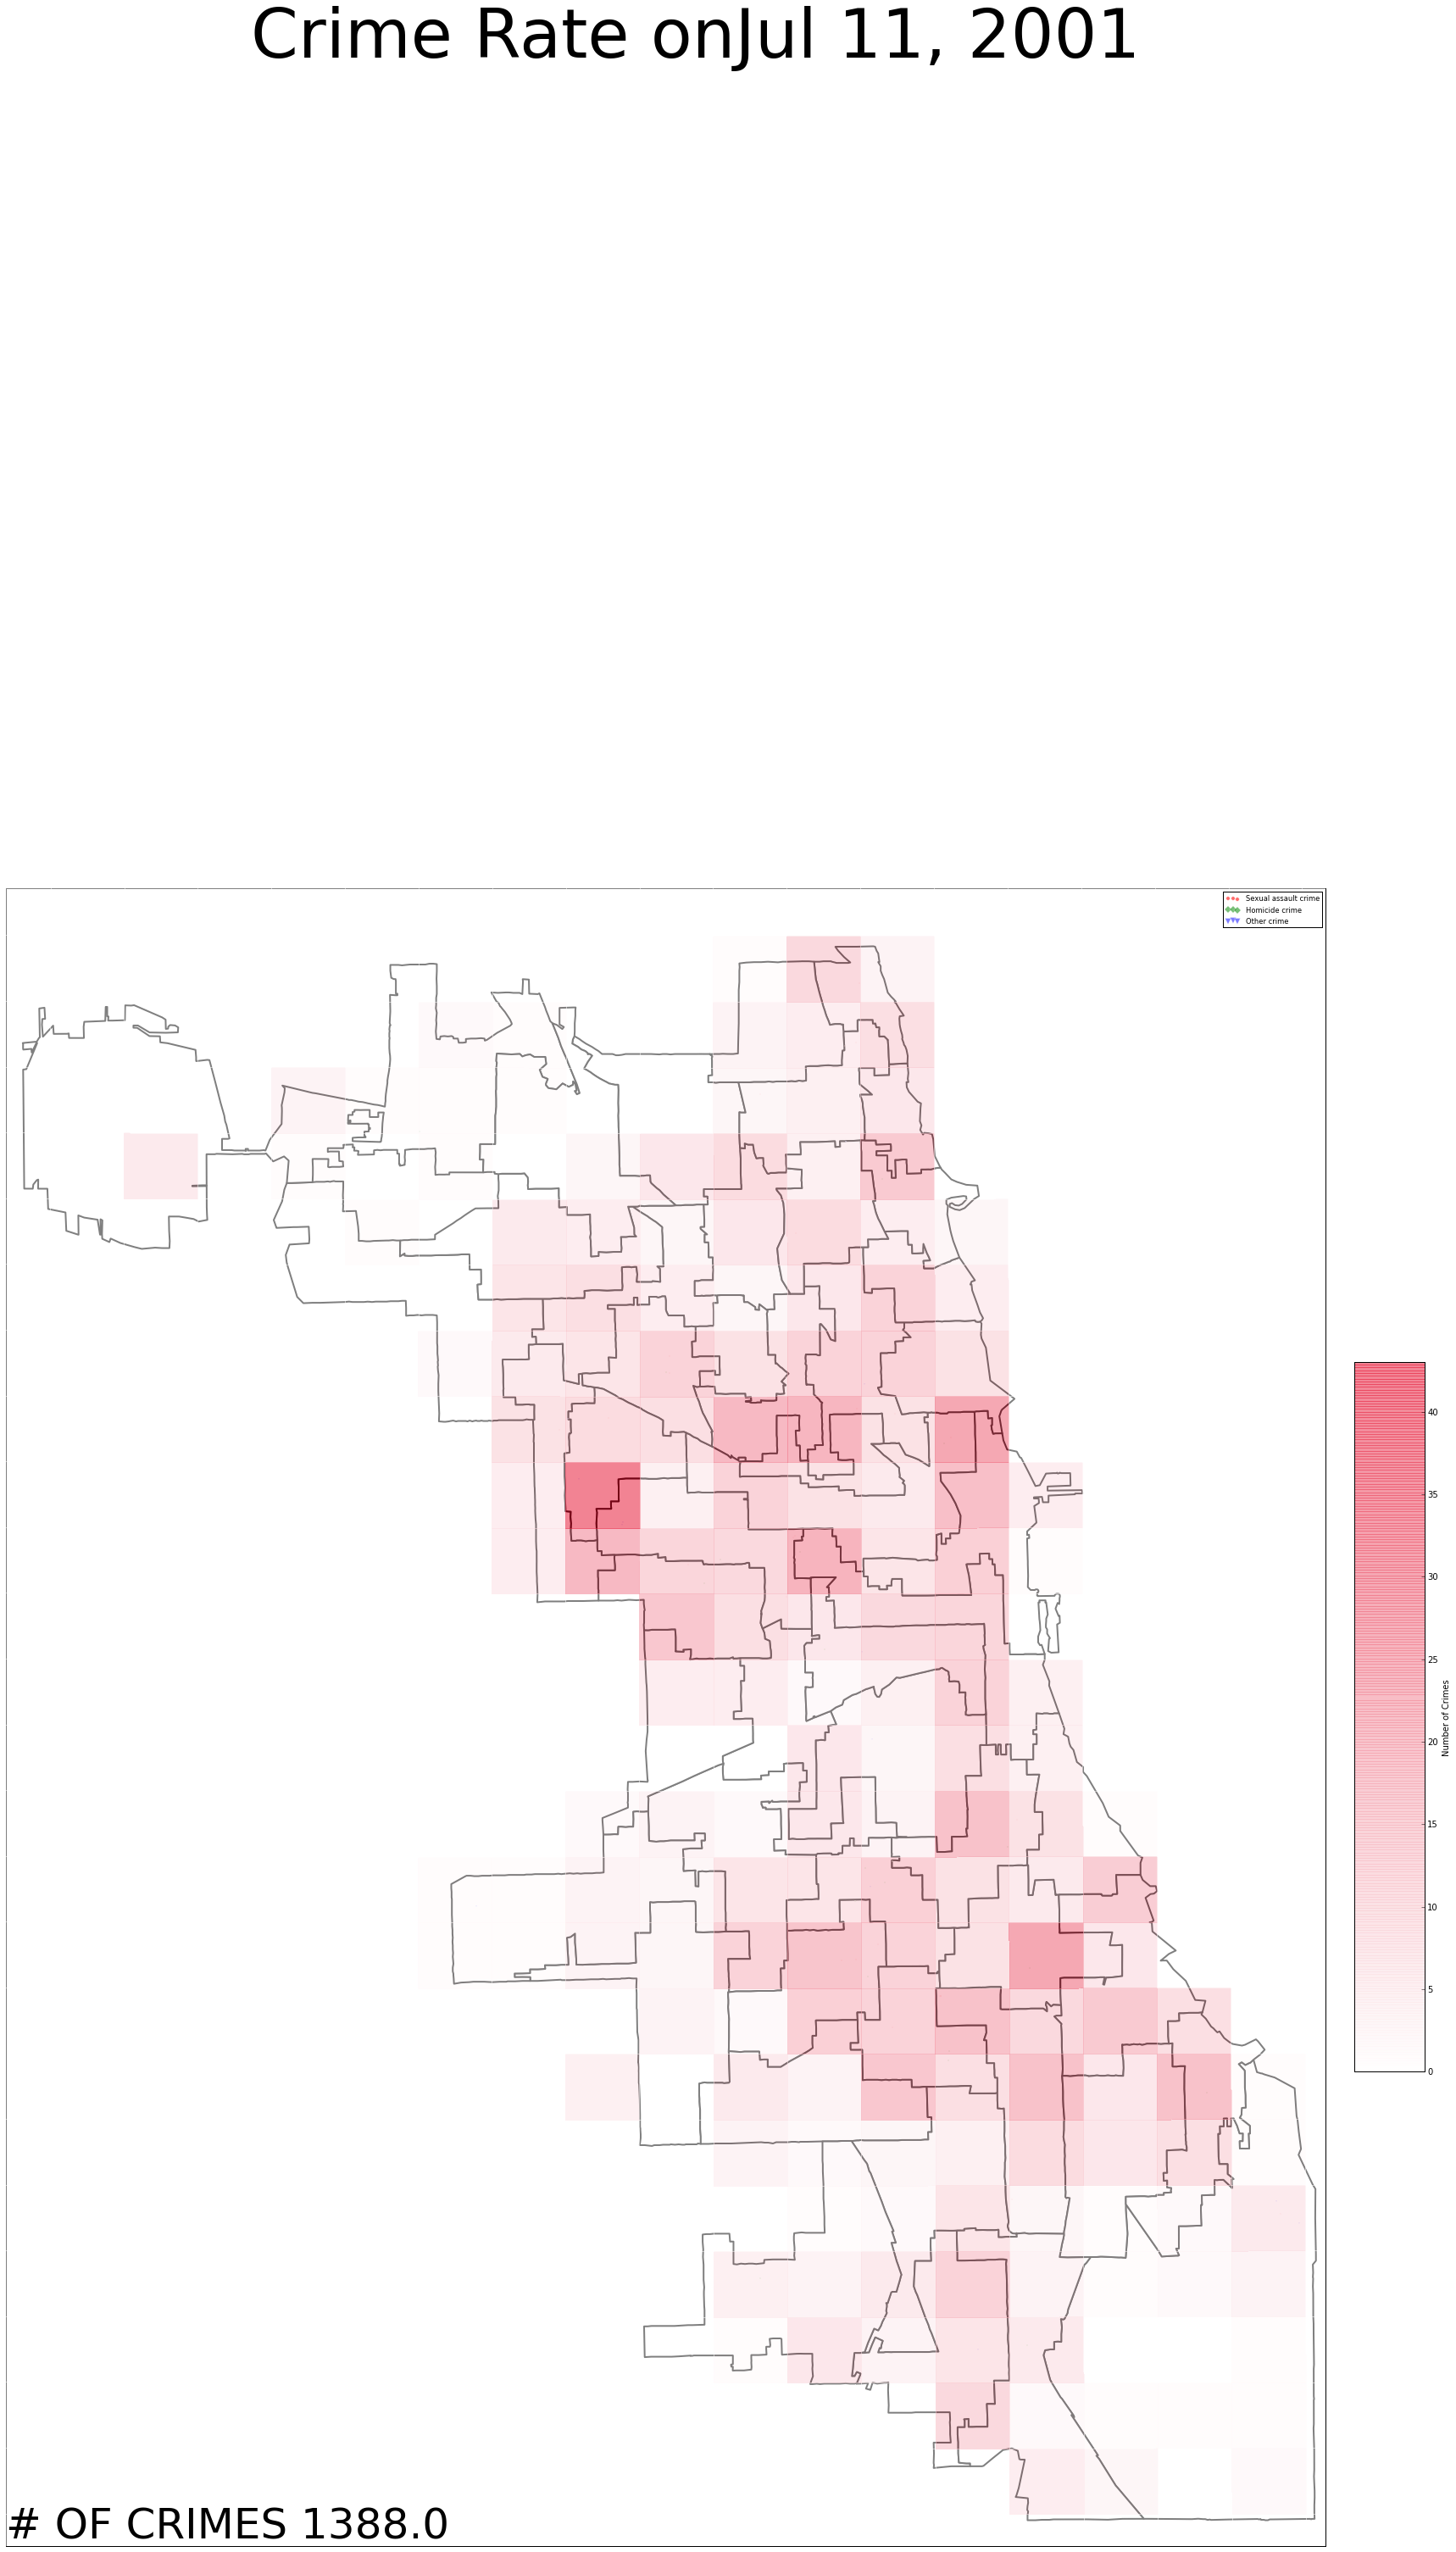

In [23]:
import matplotlib.patches as patches
## Run code with options
argv=['-d', '07/11/2001', '-o']
mode=0
areaSize=7
megaDf=pd.DataFrame(columns=['Primary Type', 'Latitude', 'Longitude'])
recordedObjects=[]
if __name__ == "__main__":
#    print mode
    try:
        opts, args = getopt.getopt(argv,"hy:m:d:eM:o",["year=", "example=", "Month="])
    except getopt.GetoptError:
#        general()
        print 'python BigDataFinalProj.py -y <year> -m <month> -d <Date(mm/dd/yyyy)> -M<Month(mm/yyyy)>'
        sys.exit(2)
        
    if '-o' in [opt for opt, _ in opts]:
        mode=1
        print mode
    for opt, arg in opts:
        if opt == '-h':
            print 'python BigDataFinalProj.py -y <year> -m <month> -d <Date(mm/dd/yyyy)> -M<Month(mm/yyyy)>'
            sys.exit()
        elif opt in ("-y", "--year"):
            yearPlot(arg)

        elif opt in ("-m", "--month"):
            mntYrPlot(arg)
        elif opt in ("-M", "--Month"):
            monthPlot(arg)
        
        elif opt in ("-d", "--date"):
            areaSize=1
            datePlot(arg)
        elif opt in ("-e", "--eentire"):
            general()

In [24]:
!ipython nbconvert --to=python BigDataFinalProject.ipynb

[NbConvertApp] Converting notebook BigDataFinalProject.ipynb to python
[NbConvertApp] Writing 19904 bytes to BigDataFinalProject.py


## RESULTS

An image in PNG format gets saved in wards1998 folder.

View results @ https://chicagocrimesite.wordpress.com/results/

## CONCLUSION

With RTM, I can identify the most vulnerable areas in a jurisdiction which allows us to predict, with a certain level of confidence. RTM is being used to help explain why spatial patterns of crime exist in a jurisdiction, and what can be done to mitigate risks, not just chase the “hotspots”. In this project, I have only demonstrated identifying of hot spots and knowing the nature of the crime at that particular hot spot. I have plotted the hot spots by measuring density at a given area. The Higher denser region is more brighter red. Police official can know the nature of crime by zooming into the hot spot and get to know what crime is mostly prevalent in that area. I would like to further extend my project to make it closer to what an RTM really is, by gathering demographic data of Chicago city we can easily determine the demographic characteristics that  may contribute the crime. For example, certain features of the built environment can increase the risk of crime, and places with high relative risk values as defined by a risk terrain model are behavior settings that present exceptionally strong likelihoods of criminal events.

## BIBLIOGRAPHY

http://stackoverflow.com/questions

http://matplotlib.org/basemap/users/examples.html

http://chrisalbon.com/python/matplotlib_plot_points_on_map.html

https://peak5390.wordpress.com/2012/12/08/matplotlib-basemap-tutorial-plotting-points-on-a-simple-map/

Packages and api documentation.

http://www.geophysique.be/tag/mpl_toolkits/